![alt text](https://static1.squarespace.com/static/5ea57eb1c6398826cb20f779/t/5ea5875b36c5d45a8f64f9f3/1595005115947/?format=180w 'DNAstack logo')


_For demonstration purposes only_

# Machine Learning Using COVID Cloud and Azure

In this notebook we will be demonstrating how to do machine learning with Azure Notebooks using SARS-CoV-2 variant data from COVID Cloud.

The machine learning in this notebook will include:

1. Linear Regression using `statsmodels`
2. K-neighest-neighbor using `scikit-learn`
3. Deep Learning Compression using TensorFlow / Keras

Before you begin, the first thing that is needed to be done is to download the libraries required for this analysis, 
and restart the notebook if necessary. In order to download the necessary libraries, make sure the `requirements.txt`
file is included in the directory.

In [5]:
%%bash

python3 -m pip install --no-cache-dir \
"dnastack-client-library" \
"plotly>=4.12.0" \
"matplotlib>=3.3.2" \
"seaborn==0.11.1" \
"jupyter" \
"ipywidgets>=7.5" \
"numpy>=1.19.2" \
"scipy>=1.5.2" \
"scikit-learn>=0.23.2" \
"statsmodels>=0.12.1" \
"pandas"

  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3 -m pip install --upgrade pip' command.


The next and most important step is to use the search library to download COVID variant data. 

There are 2 main tables we want to use for the analysis:
- Variant table
- Meta table 

The following downloads should be complete in less than a minute.

In [6]:
import pandas as pd
from dnastack import PublisherClient

#### Create the client
dataconnect_url = 'https://collection-service.publisher.dnastack.com/collection/library/search/'
publisher_client = PublisherClient(dataconnect_url=dataconnect_url)

#### Download metadata
print('Fetching metadata from DNAstack…')
query = "SELECT * FROM covid.cloud.sequences WHERE collection_date < date('2020-07-01')"
meta_df = pd.DataFrame(publisher_client.dataconnect.query(query))
print("Metadata:")
print(meta_df)

#### Download variant data
print('Fetching variants from DNAstack…')
query = """
SELECT v.*
FROM covid.cloud.variants AS v JOIN covid.cloud.sequences AS s ON s.accession = sequence_accession
WHERE s.collection_date < date('2020-07-01')
"""
variant_df = pd.DataFrame(publisher_client.dataconnect.query(query))
print("Variant Data:")
print(variant_df)

Fetching metadata from DNAstack…
Metadata:
       accession  sequence_length          host      isolation_source  \
0       MT385456          29862.0  Homo sapiens                  None   
1       MT385485          29835.0  Homo sapiens                  None   
2       MT438736          29862.0  Homo sapiens                  None   
3       MT385434          29893.0  Homo sapiens                  None   
4       MT385480          29836.0  Homo sapiens                  None   
...          ...              ...           ...                   ...   
111567  MN938384          29838.0  Homo sapiens        oronasopharynx   
111568  MN938388            107.0  Homo sapiens                 blood   
111569  MN975262          29891.0  Homo sapiens  lung, oronasopharynx   
111570  MN975267            107.0  Homo sapiens        oronasopharynx   
111571  MW565821          29875.0  Homo sapiens                  None   

                  location collection_date release_date data_source  \
0        

## 1. Linear Regression using Statsmodels
In this example, you will be using the `statsmodels` library to perform linear regression to 
find out what the rate of change of a particular variant is.

In [7]:
import numpy as np
import statsmodels.api as sm

from datetime import timedelta

##### Release date --> Day of the year
meta_df.release_date = meta_df.release_date.astype('datetime64').apply(lambda x: (x - timedelta(days=x.dayofweek)))

##### Get positions for SNP of interest
accessions = variant_df[variant_df.start_position == 23402].sequence_accession
pos_count = meta_df[(meta_df.accession.isin(accessions))].groupby('release_date').count().host
neg_count = meta_df[~(meta_df.accession.isin(accessions))].groupby('release_date').count().host

##### Merge dataframes
merge_df = pd.merge(neg_count, pos_count, left_index=True, right_index=True, how='inner').fillna(0)

##### Linear regression
y = merge_df.host_y / merge_df.sum(axis=1)
x = sm.add_constant(np.arange(len(y)))
model = sm.OLS(y, x).fit()
b1 = model.params[1].round(3)
p = model.pvalues[1].round(3)
print(f'The weekly rate of change is {b1} with a p-value of {p}')

The weekly rate of change is 0.005 with a p-value of 0.011


## 2. K-nearest-neighbor using Scikit-learn

In this example, scikit-learn is used to perform clustering with the K-nearest-neighbor algorithm. The goal of this analysis is to see whether there is a difference in the mutation profiles of American and Australian samples.

KNN model with training accuracy of : 0.8453984640564018


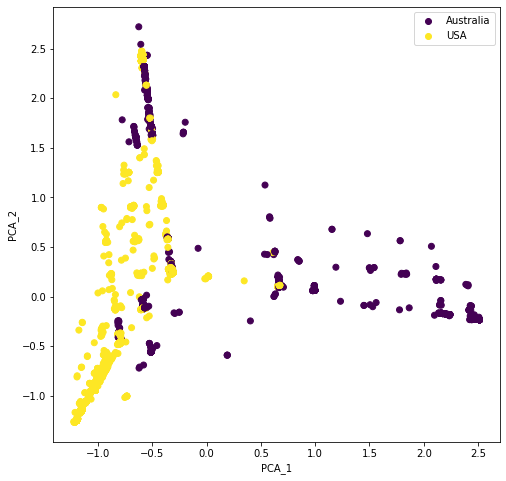

In [8]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

##### Get the meta dataframe of USA, Australia
meta_df_oi = meta_df[(meta_df.location == 'USA') |
                     (meta_df.location == 'Australia: Victoria')]

##### Filter variant_df by meta_df accessions
v_df = variant_df[variant_df.sequence_accession.isin(meta_df_oi.accession)]

##### Get the top 100 most prevalent mutations
v_df = v_df[v_df.start_position.isin(v_df.start_position.value_counts().head(100).index)]

##### Crosstab
ct = pd.crosstab(v_df.sequence_accession, v_df.start_position)

##### Get locations (y-variable)
locations = pd.merge(ct,
                     meta_df_oi[['accession', 'location']],
                     left_index=True,
                     right_on='accession').location

##### Cross tabbed data to pca
X_pca = PCA(n_components=2).fit_transform(ct.values)

##### KNN classification
knn = KNeighborsClassifier().fit(X_pca, locations)

##### Predictions
predictions = knn.predict(X_pca)

##### Figure
fig = plt.figure(figsize=(8, 8))

##### Plot
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=(predictions == 'USA').astype(int))

##### Labels
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')

##### Legend
plt.legend(handles=scatter.legend_elements()[0], labels=['Australia', 'USA'])

##### Accuracy
print('KNN model with training accuracy of :', knn.score(X_pca, locations))

## 3. Deep Learning Compression using TensorFlow / Keras
In this example you will be using TensorFlow to compress variant data in order to capture meaningful insights while reducing the size of the variant matrix.

Because `tensorflow` is a massive library, its installation is placed seperatly here. Run the cell below to install `tensorflow`. The entire download should take <5 minutes.

In [9]:
pip install --no-cache-dir tensorflow>=2.4.1

     |████████████████████████████████| 173.9 MB 2.3 MB/s 
     |████████████████████████████████| 42 kB 2.6 MB/s 
     |████████████████████████████████| 57 kB 2.1 MB/s 
     |████████████████████████████████| 15.6 MB 1.2 MB/s 
     |████████████████████████████████| 5.8 MB 72 kB/s 
     |████████████████████████████████| 3.0 MB 1.5 MB/s 
     |████████████████████████████████| 3.3 MB 433 kB/s 
     |████████████████████████████████| 462 kB 351 kB/s 
     |████████████████████████████████| 132 kB 402 kB/s 
     |████████████████████████████████| 65 kB 1.2 MB/s 
     |████████████████████████████████| 288 kB 1.4 MB/s 
     |████████████████████████████████| 3.5 MB 657 kB/s 
     |████████████████████████████████| 781 kB 1.1 MB/s 
     |████████████████████████████████| 97 kB 1.9 MB/s 
     |████████████████████████████████| 146 kB 1.8 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  At

KNN model with training accuracy of : 0.8412438625204582


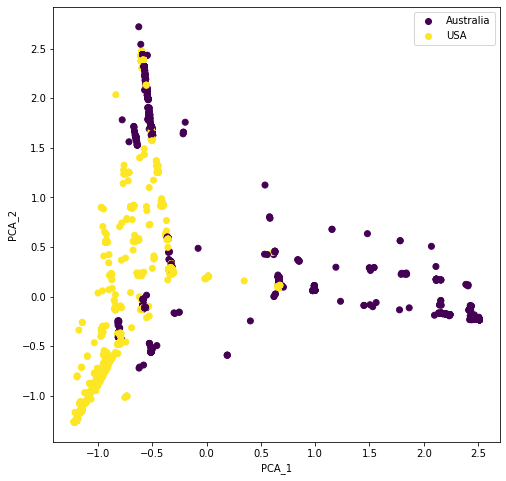

In [10]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

##### Get the meta dataframe of USA, Australia
meta_df_oi = meta_df[(meta_df.location == 'USA') |
                     (meta_df.location == 'Australia: Victoria')]

##### Filter variant_df by meta_df accessions
v_df = variant_df[variant_df.sequence_accession.isin(meta_df_oi.accession)]

##### Get the top 100 most prevalent mutations
v_df = v_df[v_df.start_position.isin(v_df.start_position.value_counts().head(100).index)]

##### Crosstab
ct = pd.crosstab(v_df.sequence_accession, v_df.start_position)

##### Get locations (y-variable)
locations = pd.merge(ct,
                     meta_df_oi[['accession', 'location']],
                     left_index=True,
                     right_on='accession').location

##### Cross tabbed data to pca
X_pca = PCA(n_components=2).fit_transform(ct.values)

##### KNN classification
knn = KNeighborsClassifier().fit(X_pca, locations)

##### Predictions
predictions = knn.predict(X_pca)

##### Figure
fig = plt.figure(figsize=(8, 8))

##### Plot
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=(predictions == 'USA').astype(int))

##### Labels
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')

##### Legend
plt.legend(handles=scatter.legend_elements()[0], labels=['Australia', 'USA'])

##### Accuracy
print('KNN model with training accuracy of :', knn.score(X_pca, locations))